# Regularisation for Inverse Problems

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from scipy.signal import convolve2d as conv2
from scipy.fft import fft2, ifft2
from skimage.util import random_noise
from skimage.restoration import wiener, richardson_lucy, denoise_tv_chambolle

# helper function for forward operator
def K(inp,psf=[],mode='forward',alpha=1e-16):
    n = inp.shape[0]
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp)
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
    if mode == 'pinv':
        g_hat = 1 / (np.conj(k_hat) * k_hat)
        g_hat[np.abs(k_hat)**2 <= alpha * np.amax(np.abs(k_hat), keepdims=False)] = 0
        outp = ifft2(( np.conj(k_hat) * inp_hat ) * (g_hat) )
        
    return np.real(outp)

# helper function for plotting
def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)

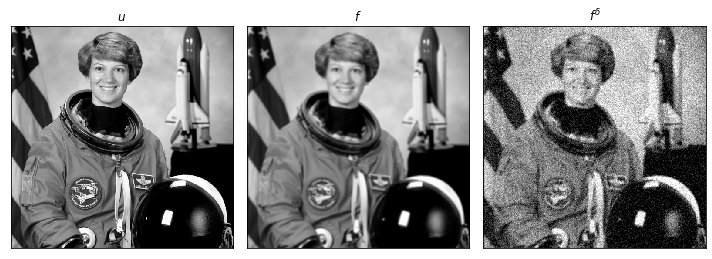

In [3]:
# read image
u = rgb2gray(data.astronaut())

# blur image
kernel = np.ones((5, 5)) / 25
f = K(u,psf=kernel)

# add_noise
delta = 0.01
f_delta = random_noise(f, var = delta, clip=False)

# plot
plot_images([u, f, f_delta], [r'$u$', r'$f$', r'$f^\delta$'], 'example1.png')

# A typical Inverse Problem ...

![](example1.png)

# Overview

* Inverse Problems
* Regularisation (linear and non-linear filters)
* Data-driven methods (dictionar learning and neural networks)

# Inverse problems in imaging

* $K$ - forward operator (convolution with PSF)
* $u$ - image (function or 2D array representing RGB values or intensity)
* $f$ - noiseless measurements ($f = Ku$)
* $f^\delta$ - noisey measurements ($f^\delta = f + \epsilon$ for additive noise)

> The goal is to retrieve $u$ given $K$ and $f^\delta$

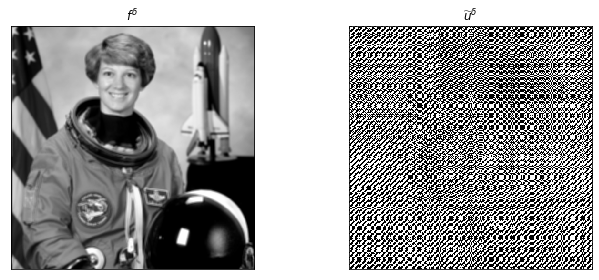

In [4]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = K(u, psf = kernel)

# add_noise
delta = 0
f_delta = random_noise(f, var = delta, clip=False)

# inverse
u_est = K(u, psf = kernel, mode = 'pinv', alpha = 1e-16)

# plot
plot_images([f_delta, u_est], [r'$f^\delta$', r'$\widetilde{u}^\delta$'], fname='decon_' + str(delta) + '.png')

We can naively retrieve the solution via deconvolution

$$\widetilde{u}^\delta = \mathcal{F}^{-1}\left(\frac{\widehat{f}^\delta}{\widehat{k}}\right).$$


This will amplify noise at frequencies for which $\widehat{k}$ is small

## $\delta = 0$
![](decon_0.png)

## Assignment

* Can you think of a way to deconvolve the image without noise by modifying the filter?
* How does this method perform when you add noise to the data?